In [1]:
# to avoid to restart kernel when external modules are modified
%load_ext autoreload
%autoreload 2

In [2]:
import os
from dotenv import load_dotenv


load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

In [3]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

In [4]:
MODEL_ID = "gemini-2.5-flash-image-preview"

from IPython.display import display, Markdown, Image
import pathlib

# Loop over all parts and display them either as text or images
def display_response(response):
    for part in response.parts:
        if part.text:
            display(Markdown(part.text))
        elif image:= part.as_image():
            display(image)
            # image.show() if not in a notebook

# Save the image
# If there are multiple ones, only the last one will be saved
def save_image(response, path):
    for part in response.parts:
        if image:= part.as_image():
            image.save(path)


In [5]:
from PIL import Image


from src.img_utils import *

748 1800


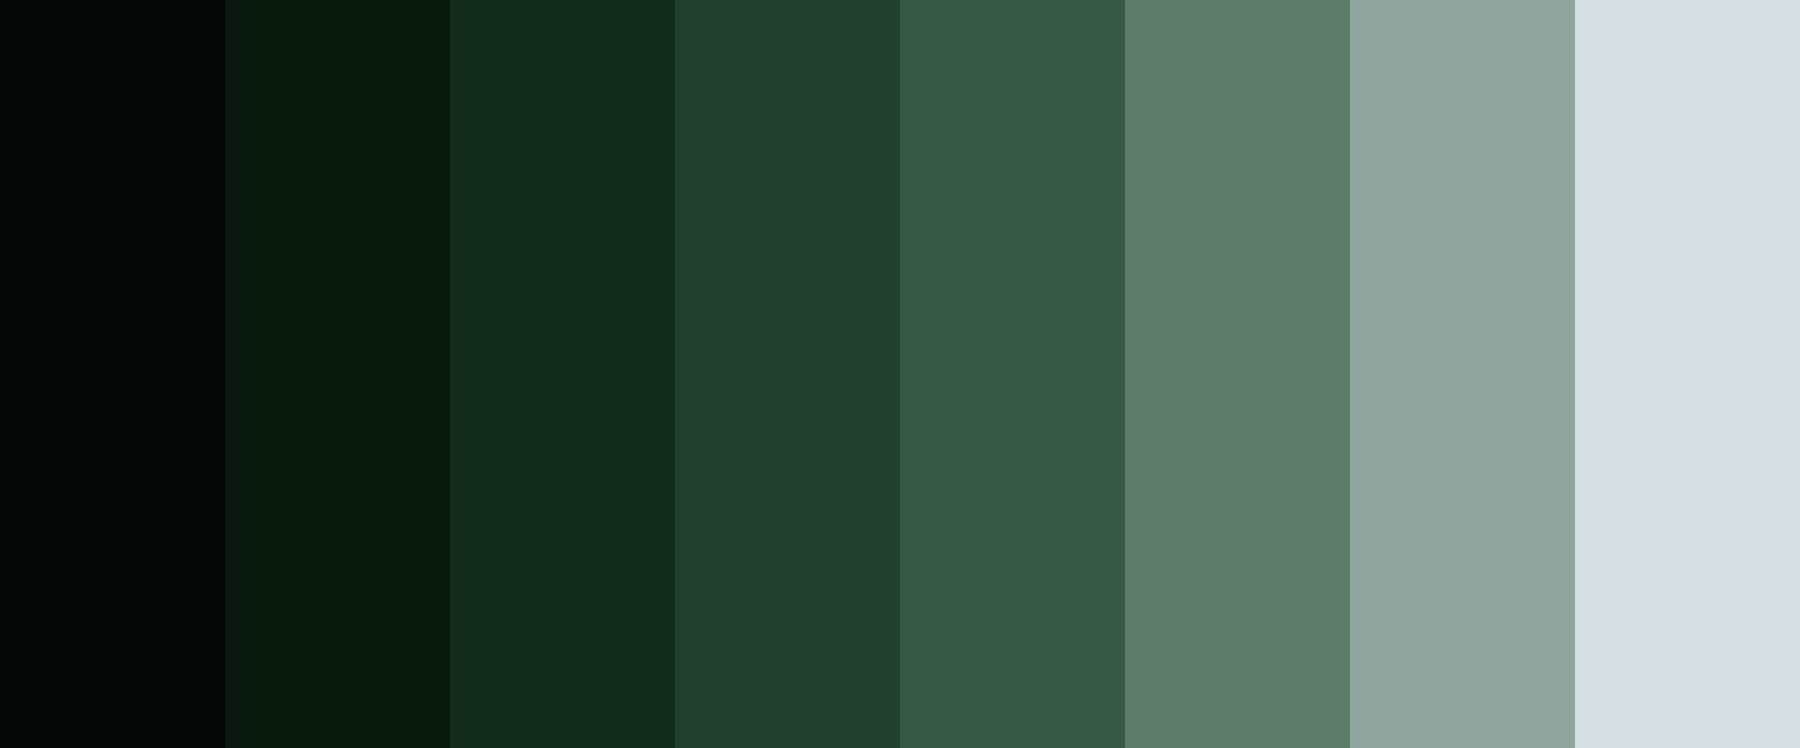

In [7]:
from pathlib import Path

base_path = Path("images")
img = Image.open(base_path / 'matrix.jpg')
target = Image.open(base_path / 'matrix.jpg')

print(img.height, img.width)

#c = generate_color_palette(x, x.height, x.width)
display(generate_color_palette(img, target))

In [ ]:
img = Image.open(base_path / 'output.png')
target = Image.open(base_path / 'matrix.jpg')

print(img.height, img.width)

#c = generate_color_palette(x, x.height, x.width)
display(generate_color_palette(img, target))

In [ ]:
text_prompt = (
    "Transfer the color style into the target image using the provided color palette image"
    " Ensure the recoloring is consistent and harmonious across the entire image, preserving details"
)

text_prompt = (
    "Recolor the target image using the provided color palette as reference." 
    " Apply the palette consistently across the entire image." 
    " Preserve details, textures, and natural shading while maintaining overall harmony and balance."
)

reference = Image.open(base_path / 'matrix.jpg')
target = Image.open(base_path / 'target2.jpeg')
palette_img = generate_color_palette(reference, target)

print("color palette extracted...")


response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        # the orden matters (idk why...)
        target,
        palette_img,
    ],
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image'],
        top_p=0.7,
    ),
)

display_response(response)